In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
file_path = "../../Datasets/BigData.xlsx"
data_title = "data_test_raw_data"
val_split, test_split = 0.2, 0.1
TRAIN_SPLIT = 68000

In [3]:
# Load data
table_of_contents = pd.read_excel(file_path, sheet_name=0, header=None)
sheet_index = table_of_contents[table_of_contents[0] == data_title][0].index[0]
sheet_data = pd.read_excel(file_path, sheet_name=sheet_index + 1, header=None)
sheet_data.columns = ['1' ,'2', '3', '4', '5', '6', '7', '8', 'N/A_1', 'N/A_2', 'angle', 'time', 'session']
rearranged_cols_force = ['time', '1' ,'2', '3', '4', '5', '6', '7', '8']
rearranged_cols_angle = ['time', 'angle']
rearranged_cols_sensors_time_invariant = rearranged_cols_force[1:] + rearranged_cols_angle[1:]

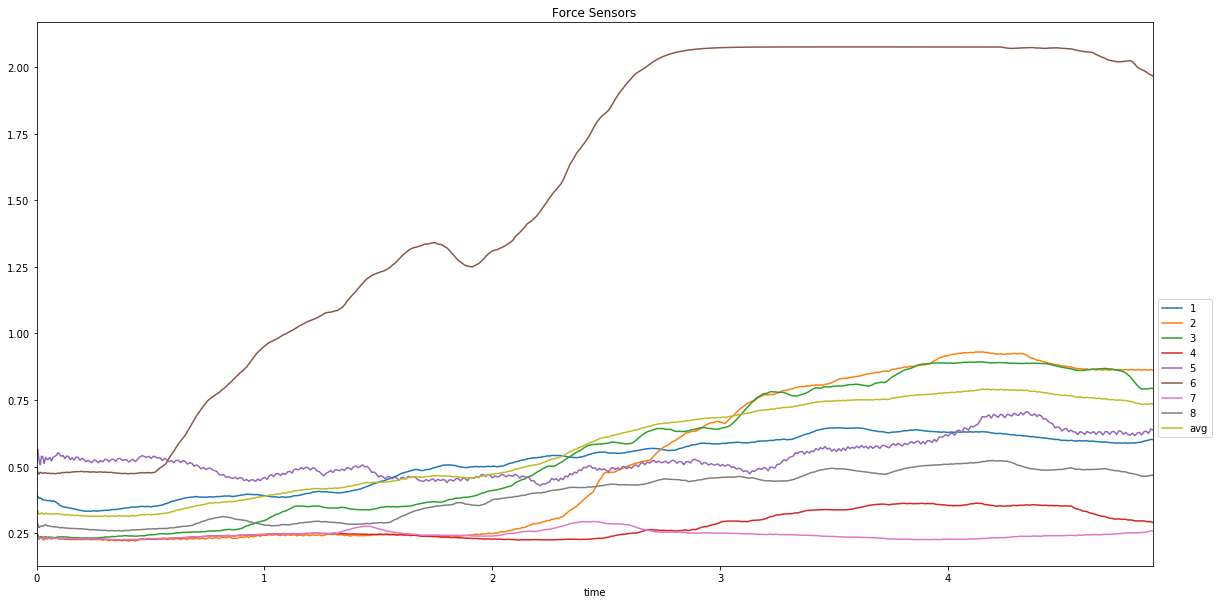

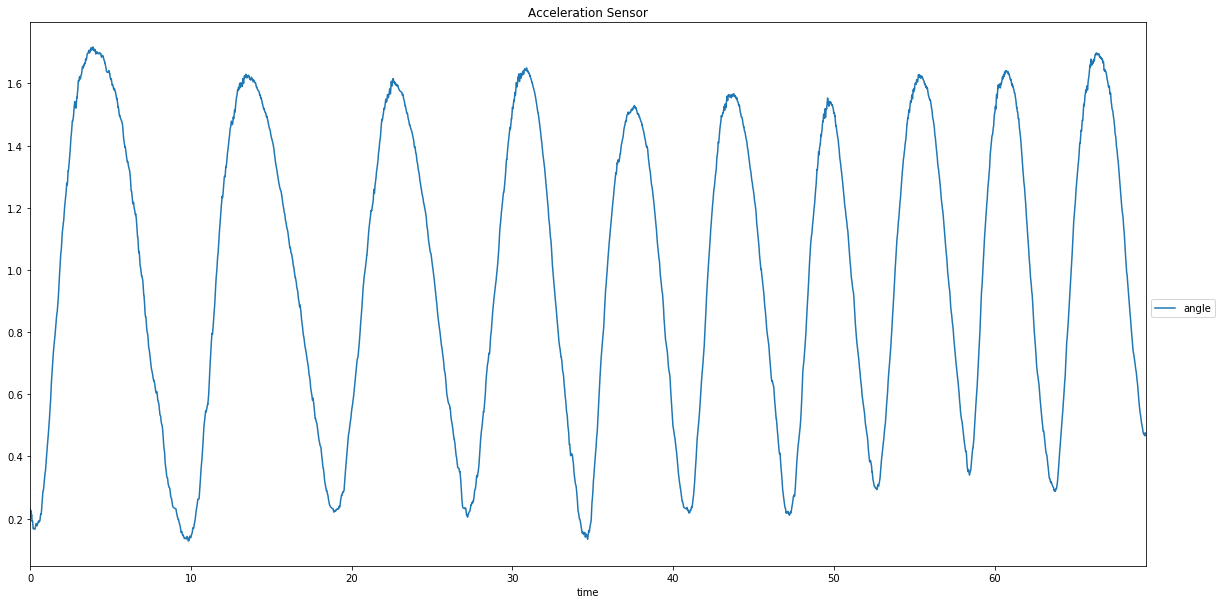

In [97]:
# Plot data

# data['time'] = data['time'].apply(lambda x : x - data['time'][0])
# Move times such that they start at 0

plt.rcParams["figure.figsize"] = (20,10)

def plot_sensorband_dataframe(df, title):
    plt = df.plot(x='time')
    plt.legend(bbox_to_anchor=(1.0, 0.5))
    plt.set_title(title)
    
SMOOTHING = 200

data_force = sheet_data[rearranged_cols_force].ewm(span=SMOOTHING).mean()
data_force['avg'] = data_force[['1' ,'2', '3', '4', '5', '6', '7', '8']].mean(axis=1)
plot_sensorband_dataframe(data_force[:5000], "Force Sensors")


data_angle = sheet_data[rearranged_cols_angle].ewm(span=SMOOTHING).mean()
plot_sensorband_dataframe(data_angle, "Acceleration Sensor")

#data_angle = data_angle['angle'].ewm(span = 10).mean()
#data_all_features = sheet_data[rearranged_cols_sensors_time_invariant]

In [5]:
features_considered = ['1' ,'2', '3', '4', '5', '6', '7', '8', 'angle', 'time']
features = sheet_data[features_considered].ewm(span=SMOOTHING).mean()
#features.index = sheet_data['time']
features = features.drop('time', axis=1)

# Dropping data, and keeping just average, if true
if True:
    features['avg'] = features.mean(axis=1)
    features = features.drop(['1' ,'2', '3', '4', '5', '6', '7', '8'], axis=1)

target = features['angle']
features = features.drop('angle', axis=1)
features.head(5)

,avg
0,0.319252
1,0.319252
2,0.321181
3,0.322145
4,0.323016


In [6]:
#features.plot(subplots=True)
target.head(5)

0    0.230691
1    0.230691
2    0.230691
3    0.230691
4    0.230691
Name: angle, dtype: float64

In [7]:
#Normalize - between values 0 to 1
from sklearn import preprocessing

x = features.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset = pd.DataFrame(x_scaled)
dataset = dataset.values

x = target.values #returns a numpy array
x = x.reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
target = pd.DataFrame(x_scaled)
target = target.values

#dataset = features.values
#data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
#data_std = dataset[:TRAIN_SPLIT].std(axis=0)
#dataset = (dataset-data_mean)/data_std

#target = target.values
#target_mean = target.mean(axis=0)
#target_std = target.std(axis=0)
#target = (target-target_mean)/target_std

#plt.plot(dataset)

In [24]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
            
    return np.array(data), np.array(labels)

def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()
    
class EarlyStoppingAtMinLoss(tf.keras.callbacks.Callback):
    def __init__(self, patience=0):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('loss')
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print('Restoring model weights from the end of the best epoch.')
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))

In [85]:
past_history = 1000#1000
future_target = 0
STEP = 100

x_train, y_train = multivariate_data(dataset, target, 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP, single_step=True)
x_val, y_val = multivariate_data(dataset, target,
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, single_step=True)

#print ('Single window of past history : {}'.format(x_train[0].shape))
#print ('\n Target to predict : {}'.format(y_train[0]))
print(len(x_train))
print(len(x_val))

print("DATA:")
print(x_train[1])
print("LABEL:")
print(y_train[1])

67999
1534
DATA:
[[0.03034393]]
LABEL:
[0.06474164]


In [86]:
BATCH_SIZE = 100
#BUFFER_SIZE = 1000

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat()
train_data = train_data.cache().batch(BATCH_SIZE)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val)).repeat()
val_data = val_data.batch(BATCH_SIZE).repeat()


#for x, y in val_data.take(0):
#    multi_step_plot(x[0], y[0], np.array([0]))

In [87]:
# This model works pretty fucking well!
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=x_train[0].shape, activation='relu'),
    tf.keras.layers.LSTM(128, return_sequences=True, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.LSTM(32, return_sequences=True, activation='relu'),
    tf.keras.layers.Dropout(0.01),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.005),
    tf.keras.layers.LSTM(8, return_sequences=False, activation='relu'),
    tf.keras.layers.Dense(1)
])

N = pow(2,8)
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, input_shape=x_train[0].shape, activation='relu'),
    #tf.keras.layers.LSTM(8,input_shape=x_train[0].shape, return_sequences=True, activation='relu'),
    #tf.keras.layers.Dropout(0.1),
    #tf.keras.layers.Dense(N//2, activation='relu'),
    #tf.keras.layers.Dropout(0.05),
    #tf.keras.layers.LSTM(8, return_sequences=True, activation='relu'),
    #tf.keras.layers.Dropout(0.01),
    #tf.keras.layers.Dense(N//16, activation='relu'),
    #tf.keras.layers.Dropout(0.005),
    #tf.keras.layers.LSTM(8, return_sequences=False, activation='relu'),
    tf.keras.layers.Dense(1)
])


model.compile(optimizer='adam', loss='mse')
#model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mean_squared_error')

In [88]:
EPOCHS = BATCH_SIZE
EVALUATION_INTERVAL = len(x_train)//BATCH_SIZE*10
VAL_STEPS = len(x_val)//BATCH_SIZE


print(x_train[0].shape)

#for x in range(0, 10):
multi_step_history = model.fit(train_data, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data,
                                          validation_steps=VAL_STEPS,
                                          callbacks=[EarlyStoppingAtMinLoss()])

(1, 1)
Train for 6790 steps, validate for 15 steps
Epoch 1/100
6790/6790 [==============================] - 9s 1ms/step - loss: 0.0076 - val_loss: 0.0036
Epoch 2/100
6790/6790 [==============================] - 9s 1ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 3/100
6790/6790 [==============================] - 9s 1ms/step - loss: 0.0022 - val_loss: 6.4573e-04
Epoch 4/100
6790/6790 [==============================] - 9s 1ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 5/100
6790/6790 [==============================] - 9s 1ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/100
6790/6790 [==============================] - 9s 1ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 7/100
6790/6790 [==============================] - 9s 1ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 8/100
6790/6790 [==============================] - 9s 1ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/100
6790/6790 [==============================] - 9s 1ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 10/100
6790/

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


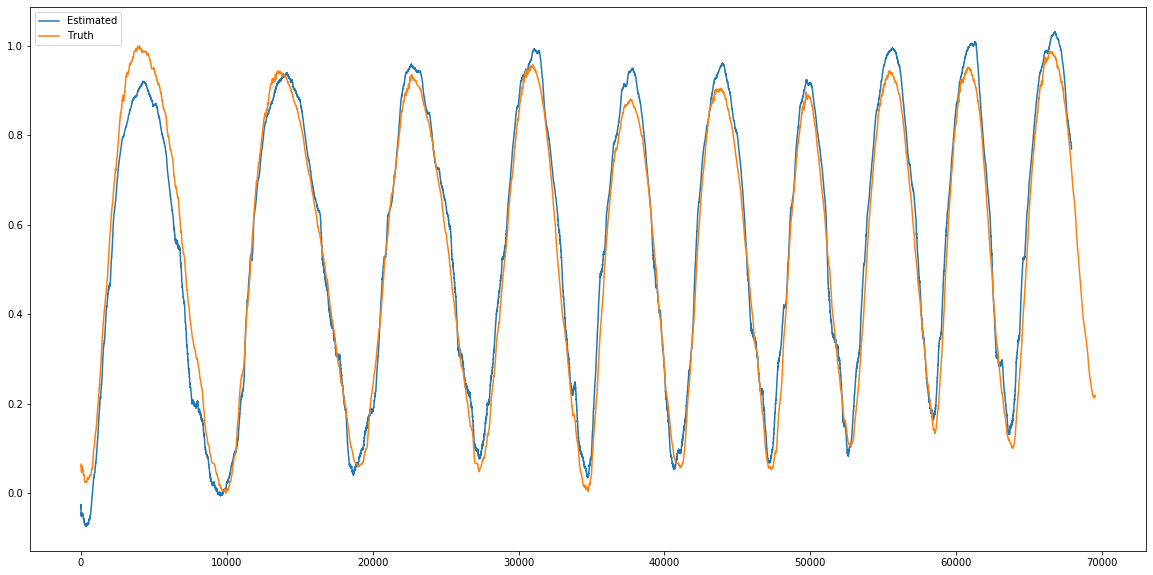

In [99]:
res = model.predict(train_data.take(len(x_train)//BATCH_SIZE))

#Y = train_data.take(1)
#X = model.predict(Y)
#print(Y)
#print(X)

#print(res)
from itertools import chain
res = list(chain(*res))

fig=plt.figure()
fig.show()
ax=fig.add_subplot(111)

import pylab
ax.plot(res, label='Estimated')
ax.plot(target[past_history:], label='Truth')
pylab.legend(loc='upper left')
plt.show()